In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


* *func_* = the function we want to describe
* *func* = the function which describes func

In [5]:
# Dataset(xys) = dataset with next_batch
# with batch

class Dataset:
    def __init__(self, xys):    # xys: Lx2

        # type(dom)=numpy.array

        np.random.shuffle(xys)  # shuffle xys
        self.xs, self.ys = np.hsplit(xys, [1]) # Lx1
        self.data = xys
        self.index = 0  # for next_batch below
        self.leng = len(xys)

    def next_batch(self, n):
        if self.index + n > self.leng:
            self.index = 0

        ind = self.index
        batch_xs = self.xs[:, ind: ind + n]
        batch_ys = self.ys[:, ind: ind + n]
        self.index += n
        return batch_xs, batch_ys


def create_graph(func_, dom):
    xs = dom
    ys = func_(dom)              # map dom with func
    return np.c_[xs, ys]         # Lx2

In [16]:
def plot_result(func, dataset, save_cond=[False, ""]):

    fig = plt.figure()
    subplot = fig.add_subplot(1, 1, 1)

    # plot func
    x_min = np.min(dataset.xs)
    x_max = np.max(dataset.xs)
    margin = (x_max - x_min) / 100
    left = x_min - margin
    right = x_max + margin
    dom = np.arange(left, right, margin)
    cod = func(dom)
    subplot.plot(dom, cod, color='red')

    # plot dataset
    xs = dataset.data[:, 0]
    y_s = dataset.data[:, 1]
    subplot.scatter(xs, y_s, color='blue')

    plt.show()
    
    [do_save, name] = save_cond
    if do_save:
        fig.savefig(name)
    fig.clf()


In [39]:
def model_5(dataset):

    # The shape of pows should be nx2 to do with the meaning

    # Create the model
    pows = tf.placeholder(tf.float32, [None, 6])
    coeffs = tf.Variable(tf.zeros([6, 1]))
    y = tf.matmul(pows, coeffs) # nx1
    
    # Define loss and optimizer
    y_ = tf.placeholder(tf.float32, [None, 1])
    error = tf.reduce_sum(tf.square(y_ - y))
    eps = 0.001
    train_step = tf.train.GradientDescentOptimizer(eps).minimize(error)

    # modify dataset
    mult = dataset.data.flatten().mean()
    dim0 = mult * np.ones(dataset.leng)
    dim1 = dataset.xs.reshape(dataset.leng)
    dim2 = dim1 * dim1
    dim3 = dim2 * dim1
    dim4 = dim3 * dim1
    dim5 = dim4 * dim1

    dataset.pows = np.c_[dim5, dim4, dim3, dim2, dim1, dim0]

    ind0 = dataset.leng - 100
    dataset.leng_100 = ind0
    dataset.test_pows = dataset.pows[ind0: ind0 + 100]
    dataset.test_ys = dataset.ys[ind0: ind0 + 100]

    def next_batch(n):
        if dataset.index + n > dataset.leng_100:
            dataset.index = 0

        ind = dataset.index
        batch_pows = dataset.pows[ind: ind + n]
        batch_ys = dataset.ys[ind: ind + n]
        dataset.index += n
        return batch_pows, batch_ys


    # Train
    init_op = tf.initialize_all_variables()
    loop_times0 = 20
    loop_times = 1000

    # dataset.leng / 10 is not so important

    with tf.Session() as sess:
        sess.run(init_op)
        log_data = []
        feed = {pows: dataset.test_pows, y_: dataset.test_ys}

        print("------------------------")

        for _ in range(loop_times0):
            batch_pows, batch_ys = next_batch(100)
            feed0={pows: batch_pows, y_: batch_ys}
            sess.run(train_step, feed_dict=feed0)
            log_data.append(sess.run(error, feed_dict=feed))
            print(sess.run(error, feed_dict=feed0))

        print("------------------------")

        for _ in range(loop_times):
            batch_pows, batch_ys = next_batch(100)
            feed0={pows: batch_pows, y_: batch_ys}
            sess.run(train_step, feed_dict=feed0)
            log_data.append(sess.run(error, feed_dict=feed))
        print("------------------------")

        for _ in range(loop_times0):
            batch_pows, batch_ys = next_batch(100)
            feed0={pows: batch_pows, y_: batch_ys}
            sess.run(train_step, feed_dict=feed0)
            log_data.append(sess.run(error, feed_dict=feed))
            print(sess.run(error, feed_dict=feed0))
        print("------------------------")
        coeffsfin = sess.run(coeffs)
        print(coeffsfin)    
        val1 = sess.run(y, feed_dict={pows: [[1, 1, 1, 1, 1, mult]]})
        val0 = sess.run(y, feed_dict={pows: [[0, 0, 0, 0, 0, mult]]})
        print(val1)
        print(val0)
        print()
    np.save("./coeffs_1.npy", coeffsfin)
    np.save("./log_data.npy", log_data)    
    
    
    # def func(x):
    #     x2 = x * x
    #     x3 = x2 * x
    #     x4 = x3 * x
    #     x5 = x4 * x
    #     pows = np.array([x5, x4, x3, x2, x, mult])
    #     return np.sum(pows * coeffsfin.reshape(6))

    coeffs_modified = coeffsfin.reshape(6)
    coeffs_modified[5] = coeffs_modified[5] * mult
    print(coeffs_modified)
    print(np.polyval(coeffs_modified, 1))
    print(np.polyval(coeffs_modified, 0))

    # return func
    return (lambda x: np.polyval(coeffs_modified, x))


In [12]:
def main(dataset, model, shower):
    shower(model(dataset), dataset)

------------------------
238.583
22.3203
2.14623
0.24037
0.0675118
0.0544062
0.0632561
0.0578924
0.0493878
0.0492742
0.0401909
0.0404389
0.0452268
0.0541783
0.0493619
0.0422722
0.0421294
0.0343639
0.034558
0.0388036
------------------------


------------------------
0.000230552
0.000297619
0.00029276
0.000230774
0.000244422
0.000237785
0.000177626
0.000229007
0.000295647
0.000290759
0.000229252
0.000242808
0.000236163
0.000176433
0.000227486
0.000293702
0.000288768
0.000227744
0.000241189
0.000234561
------------------------
[[ 0.00324492]
 [ 0.00928227]
 [ 0.01232703]
 [ 0.06206676]
 [ 0.00578322]
 [ 1.95898926]]
[[ 5.09383392]]
[[ 5.00112963]]

[  3.24492226e-03   9.28226858e-03   1.23270294e-02   6.20667562e-02
   5.78322029e-03   5.00112963e+00]
5.09383382392
5.00112962723


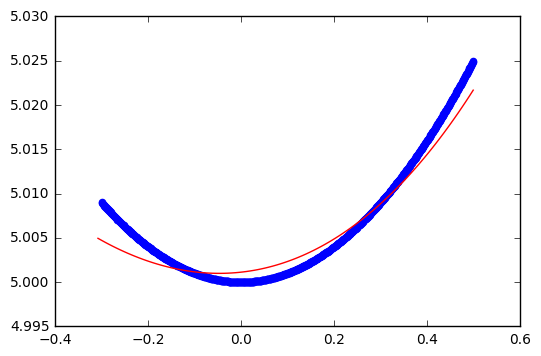

In [43]:
def my_po(x):
    return (0.001 * x**5 + 0.1 * x**2 + 5)
def my_sigmo(x):
    a = np.exp(2 * x)
    return (a - 1) / (a + 1)
# plot_result(func, dataset, save_cond=[False, ""]):
xys = np.arange(-0.3, 0.5, 0.001)
main(Dataset(create_graph(my_po, xys)), model_5, plot_result)

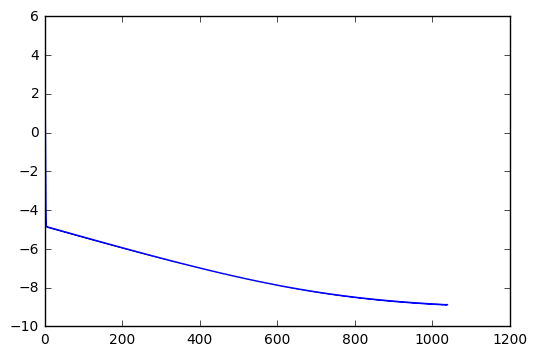

In [35]:
def draw_error():
    log_data = np.load("./log_data.npy")
    fig = plt.figure()
    sub_plot = fig.add_subplot(1, 1, 1)
    xs = np.arange(log_data.size)
    ys = np.log(log_data)
    sub_plot.plot(xs, ys)
    plt.show()
    fig.clf()
draw_error()